# NA Imputation

We need to impute values for missing Age and Fare values

In [99]:
library(here)
setwd(here())
print(getwd())
source(file="misc_functions.R")
source("experiments/titanic_challenge/1_feature_engineering.R")

library(lattice)
library(gridExtra)
library(mice)

[1] "/home/sapristi/Documents/ML"


In [32]:
train.raw <- read.csv("datasets/titanic_na/train.csv")
train <- fe$forge_features_add(train.raw)

print(colnames(train))

 [1] "PassengerId" "Survived"    "Pclass"      "Name"        "Sex"        
 [6] "Age"         "SibSp"       "Parch"       "Ticket"      "Fare"       
[11] "Cabin"       "Embarked"    "Title"       "Fare.sqrt"   "Fare.log"   
[16] "Age.simple"  "Age.disc3"   "Age.disc5"   "Deck"       


In [152]:
make_imputations <- function(data, m, methods, formulas) {
    imps <- list();
    for (meth in methods) {
        tryCatch({
            imps[[meth]] <- mice(data, m, method=meth, printFlag = FALSE, formulas = formulas) }, 
                 error =  function(e) {cat("Error with method ", meth, "\n")})
    }
    return(imps)
}

# 1 Comparing methods for Age (continuous)

In [159]:
methods <- c("pmm", "midastouch", "sample", "cart", "rf", "norm")
age.imps <- make_imputations(train, m=5, methods = methods,  formulas = list(Age = Age ~ Title + Fare))

age.stripplots <- lapply(age.imps, function(imp) {stripplot(imp, Age ~ Title, main=imp$method["Age"])})

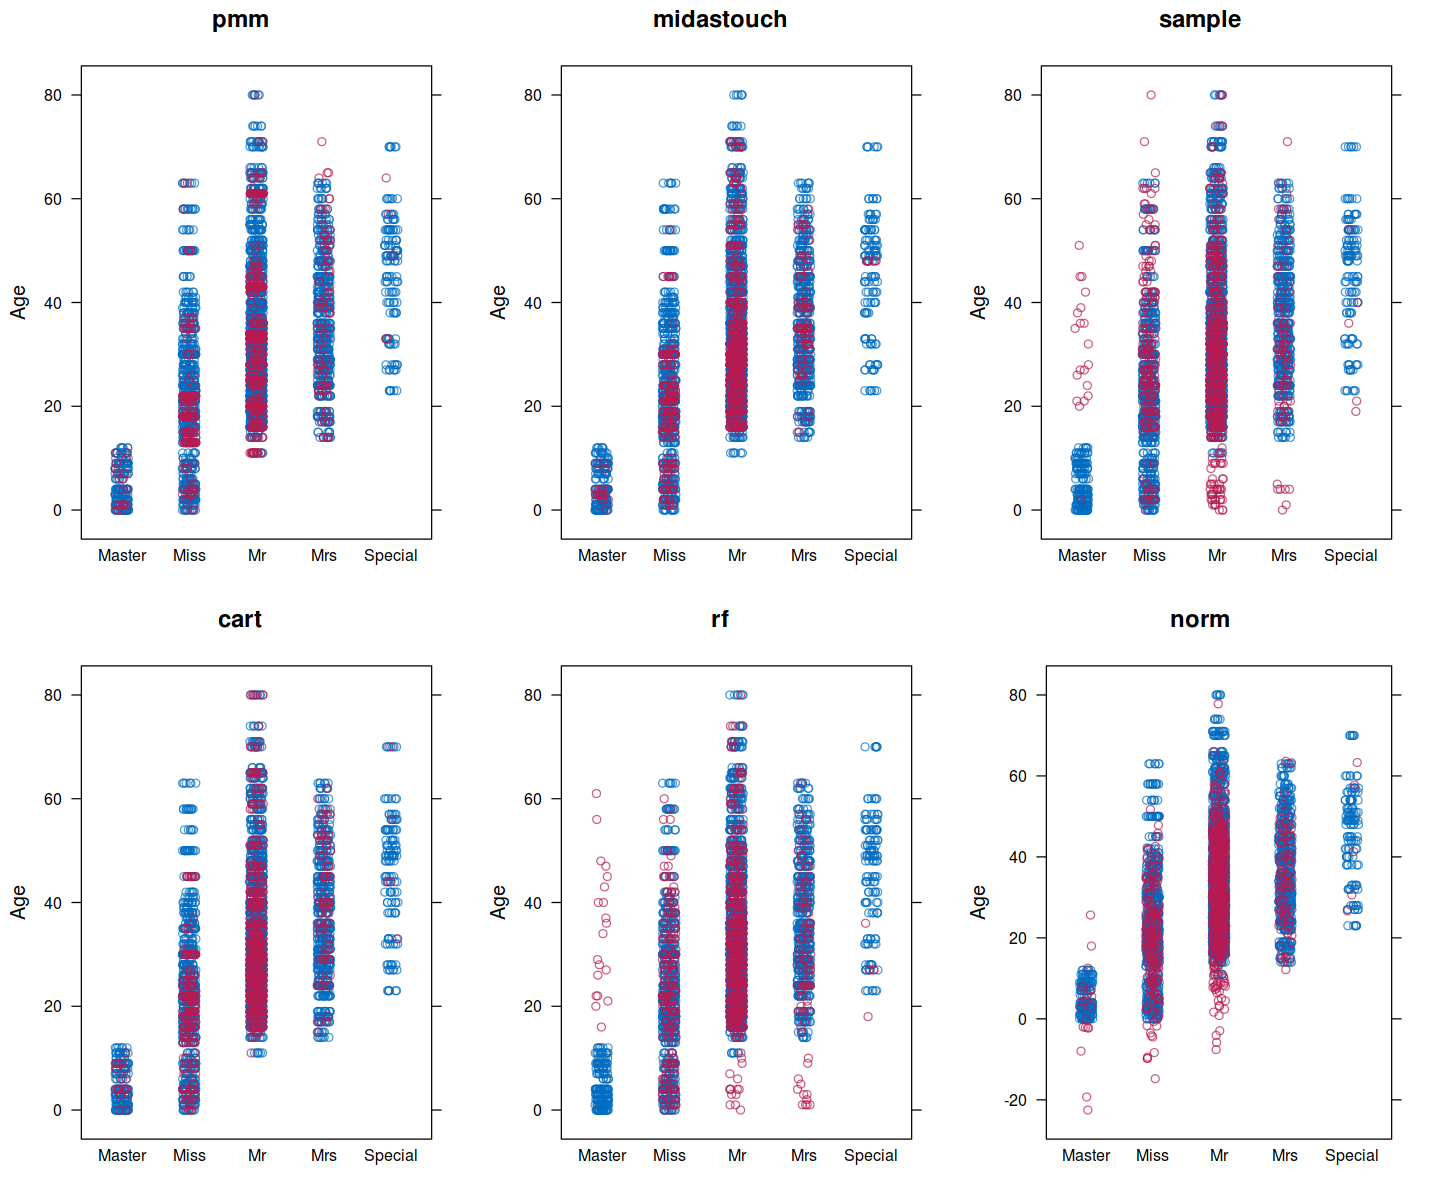

In [160]:
options(repr.plot.height= 10,repr.plot.width= 12)
grid.arrange(grobs = age.stripplots, nrow = 2)

Models that keep age imputation consistent with title are `pmm`, `midastouch` and `cart`, but it is difficult to separate those three.
Let's see what density curves give us for those models.

In [163]:
methods <- c("pmm", "midastouch", "cart")
age.imps <- make_imputations(train, m=30, methods = methods,  formulas = list(Age = Age ~ Title + Fare))
age.densityplots <- lapply(age.imps, function(imp) {densityplot(imp, ~Age,  main=imp$method["Age"])})

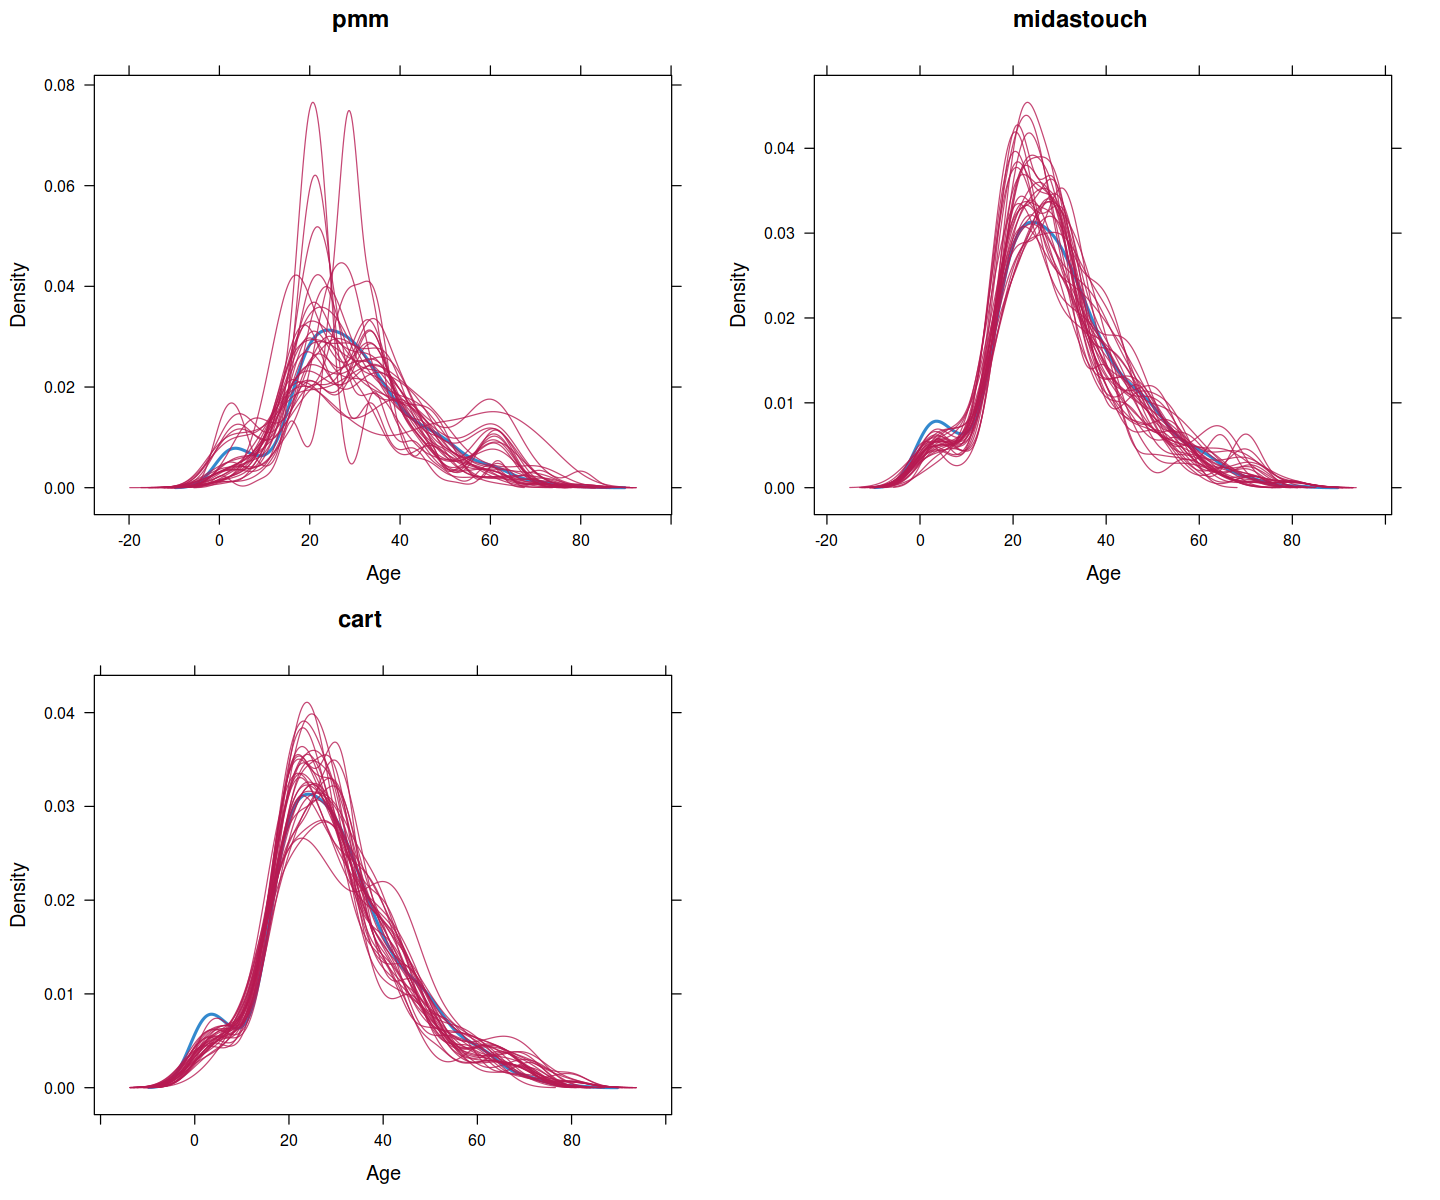

In [164]:
grid.arrange(grobs = age.densityplots, nrow = 2)

We can rule out `pmm`, remains `midastouch` and `cart`, and `cart` seems more regular, so `cart` it will be !

# 2 Comparing methods for Age (discrete 5)

Age.disc5 is not really discrete, so we will use the same models as above

In [167]:
methods <- c("pmm", "midastouch", "sample", "cart", "rf", "norm")
age5.imps <- make_imputations(train, m=5, methods = methods,  formulas = list(Age.disc5 = Age.disc5 ~ Title + Fare))

age5.stripplots <- lapply(age5.imps, function(imp) {stripplot(imp, Age.disc5 ~ Title, main=imp$method["Age.disc5"])})

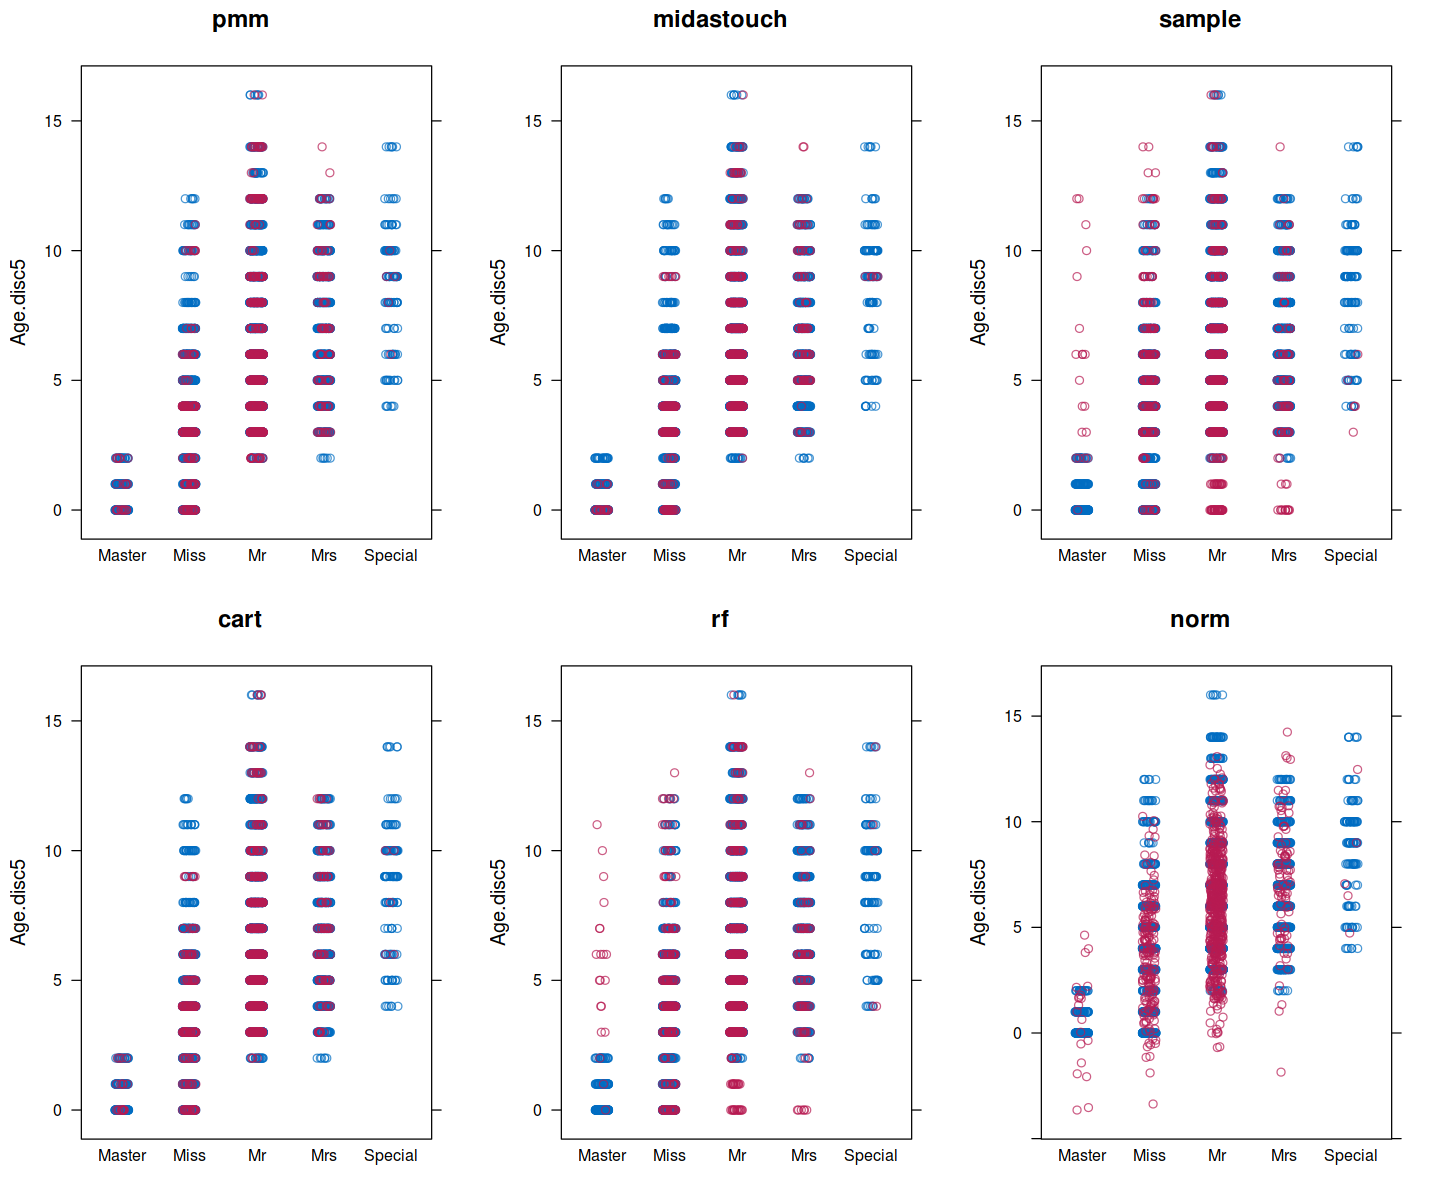

In [168]:
options(repr.plot.height= 10,repr.plot.width= 12)
grid.arrange(grobs = age5.stripplots, nrow = 2)

In [171]:
methods <- c("pmm", "midastouch", "cart")
age5.imps <- make_imputations(train, m=20, methods = methods,  formulas = list(Age.disc5 = Age.disc5 ~ Title + Fare))
age5.densityplots <- lapply(age5.imps, function(imp) {densityplot(imp, ~Age.disc5,  main=imp$method["Age.disc5"])})

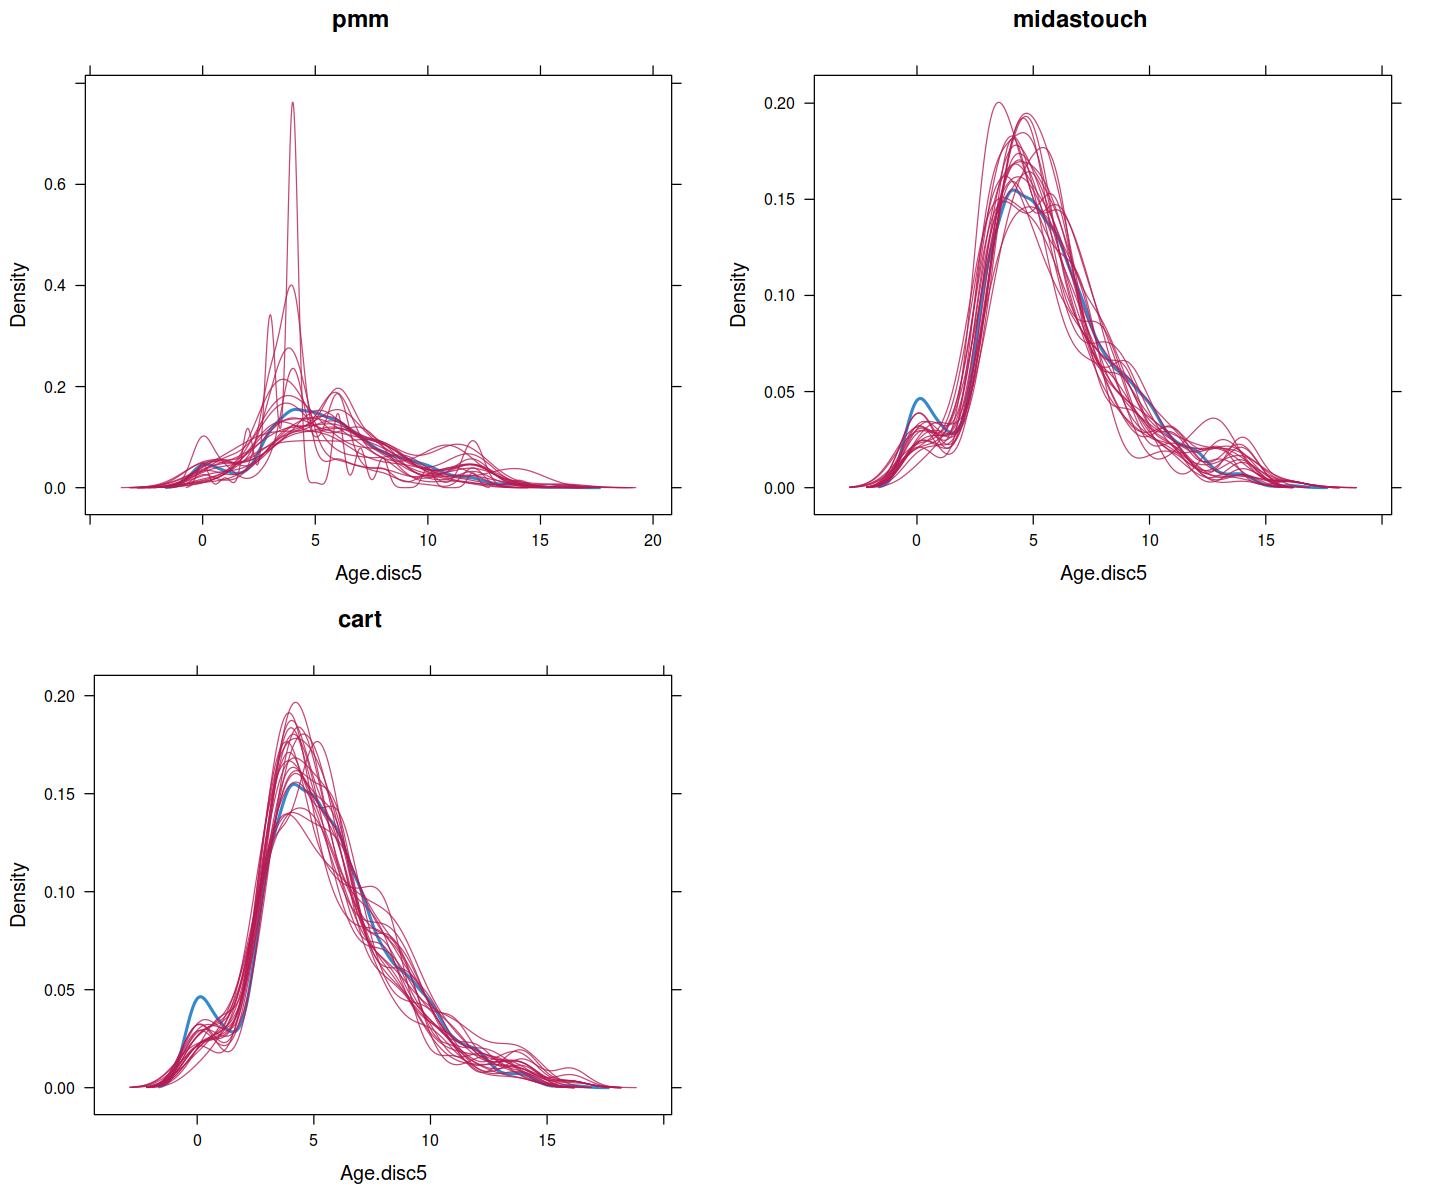

In [172]:
options(repr.plot.height= 10,repr.plot.width= 12)
grid.arrange(grobs = age5.densityplots, nrow = 2)

Once again,  `cart` seems to give good results. 

# 3 Comparing methods for Age (simple)

Age.simple should really be treated as a factor, so we can also use logistic regression models. Let's try them out !


In [173]:
methods <- c("pmm", "midastouch", "sample", "cart", "logreg", "logreg.boot", "2l.norm", "2l.lmer", "2l.pan")

imps.age.simple <- make_imputations(train, m=5, methods = methods, formulas = list(Age.simple = Age.simple ~ Title + Fare))

Warning message in `[<-.factor`(`*tmp*`, cc, value = c(1, 1, 1, 1, 1, 1, 2, 1, 1, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, cc, value = c(1, 1, 1, 1, 1, 1, 1, 1, 1, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, cc, value = c(1, 1, 1, 1, 1, 1, 1, 1, 1, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, cc, value = c(1, 1, 1, 1, 1, 1, 2, 1, 1, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, cc, value = c(1, 1, 1, 1, 3, 1, 1, 1, 3, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, cc, value = c(1, 1, 2, 1, 1, 1, 1, 1, 1, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, cc, value = c(1, 1, 1, 1, 1, 1, 1, 1, 1, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, cc, value = c(1, 1, 1, 1, 1, 1, 2, 1, 1, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`,

Error with method  logreg 


Warning message:
“Type mismatch for variable(s): Age.simple
Imputation method logreg.boot is not for factors with >2 levels.”

Error with method  logreg.boot 


Warning message:
“Type mismatch for variable(s): Age.simple
Imputation method 2l.norm is not for factors with >2 levels.”

Error with method  2l.norm 


Warning message in mice.impute.2l.lmer(y = structure(c(1L, 1L, 1L, 1L, 1L, 1L, 2L, :
“lmer does not run. Simplify imputation model”Warning message in mice.impute.2l.lmer(y = structure(c(1L, 1L, 1L, 1L, 1L, 1L, 2L, :
“lmer does not run. Simplify imputation model”Warning message in mice.impute.2l.lmer(y = structure(c(1L, 1L, 1L, 1L, 1L, 1L, 2L, :
“lmer does not run. Simplify imputation model”Warning message in mice.impute.2l.lmer(y = structure(c(1L, 1L, 1L, 1L, 1L, 1L, 2L, :
“lmer does not run. Simplify imputation model”Warning message in mice.impute.2l.lmer(y = structure(c(1L, 1L, 1L, 1L, 1L, 1L, 2L, :
“lmer does not run. Simplify imputation model”Warning message in mice.impute.2l.lmer(y = structure(c(1L, 1L, 1L, 1L, 1L, 1L, 2L, :
“lmer does not run. Simplify imputation model”Warning message in mice.impute.2l.lmer(y = structure(c(1L, 1L, 1L, 1L, 1L, 1L, 2L, :
“lmer does not run. Simplify imputation model”Warning message in mice.impute.2l.lmer(y = structure(c(1L, 1L, 1L, 1L, 1L, 1L, 2L, 

Error with method  2l.pan 


Ok, so apparently additional methods are only usable when factors have two levels, let's stick with the previous methods.

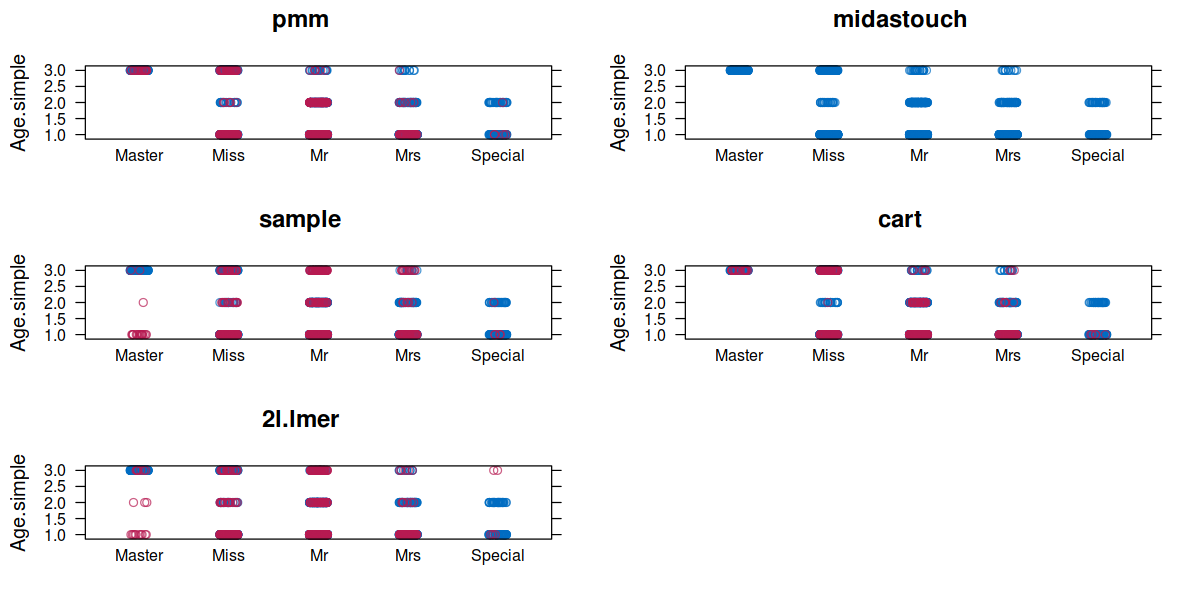

In [139]:
stripplots <- lapply(imps.age.simple, function(imp) {stripplot(imp, Age.simple ~ Title, main=imp$method["Age.simple"])})
options(repr.plot.height=5,repr.plot.width= 10)

grid.arrange(grobs = stripplots, nrow = 3)

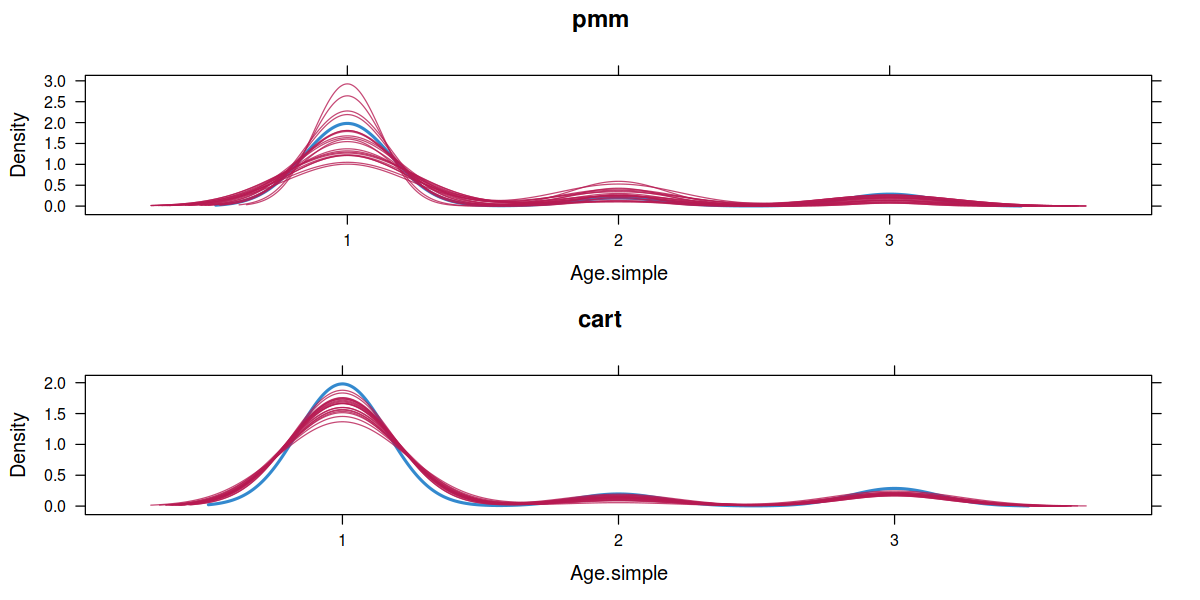

In [147]:

imps.age.simple <- make_imputations(train, m=20, methods = c("pmm", "cart"), formulas = list(Age.simple = Age.simple ~ Title + Fare))

densityplots <- lapply(imps.age.simple[ c("pmm", "cart")], function(imp) {densityplot(imp, ~ Age.simple , main=imp$method["Age.simple"])})
grid.arrange(grobs = densityplots, nrow = 2)

Once again, `cart` seems to lead to less aberration. `pmm` is not completely to exclude though, it might be usefull to compare.

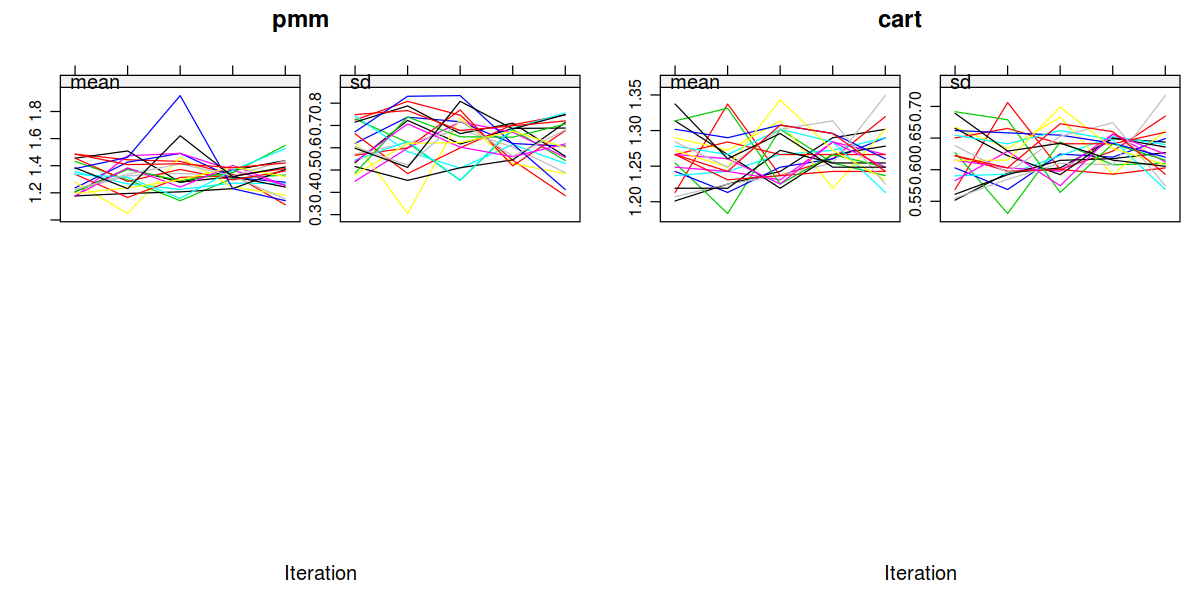

In [151]:
impplots <- lapply(imps.age.simple[c("pmm", "cart")], function(imp) plot(imp,  main=imp$method["Age.simple"]))
grid.arrange(grobs = impplots, nrow = 1)

# Comparing methods for Fare 

Let's first add imputed age so that we can use the data.

In [245]:
train$Age.imp <- complete(age.imps$cart, 1)$Age
summary(train$Age.imp)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   21.00   28.00   29.61   38.00   80.00       8 

In [246]:
methods <- c("pmm", "midastouch", "sample", "cart")
train$Pclass <- as.factor(train$Pclass)
fare.imps <- make_imputations(train, m=5, methods = methods, formulas = list(Fare = Fare ~  Title  + Embarked + Pclass))

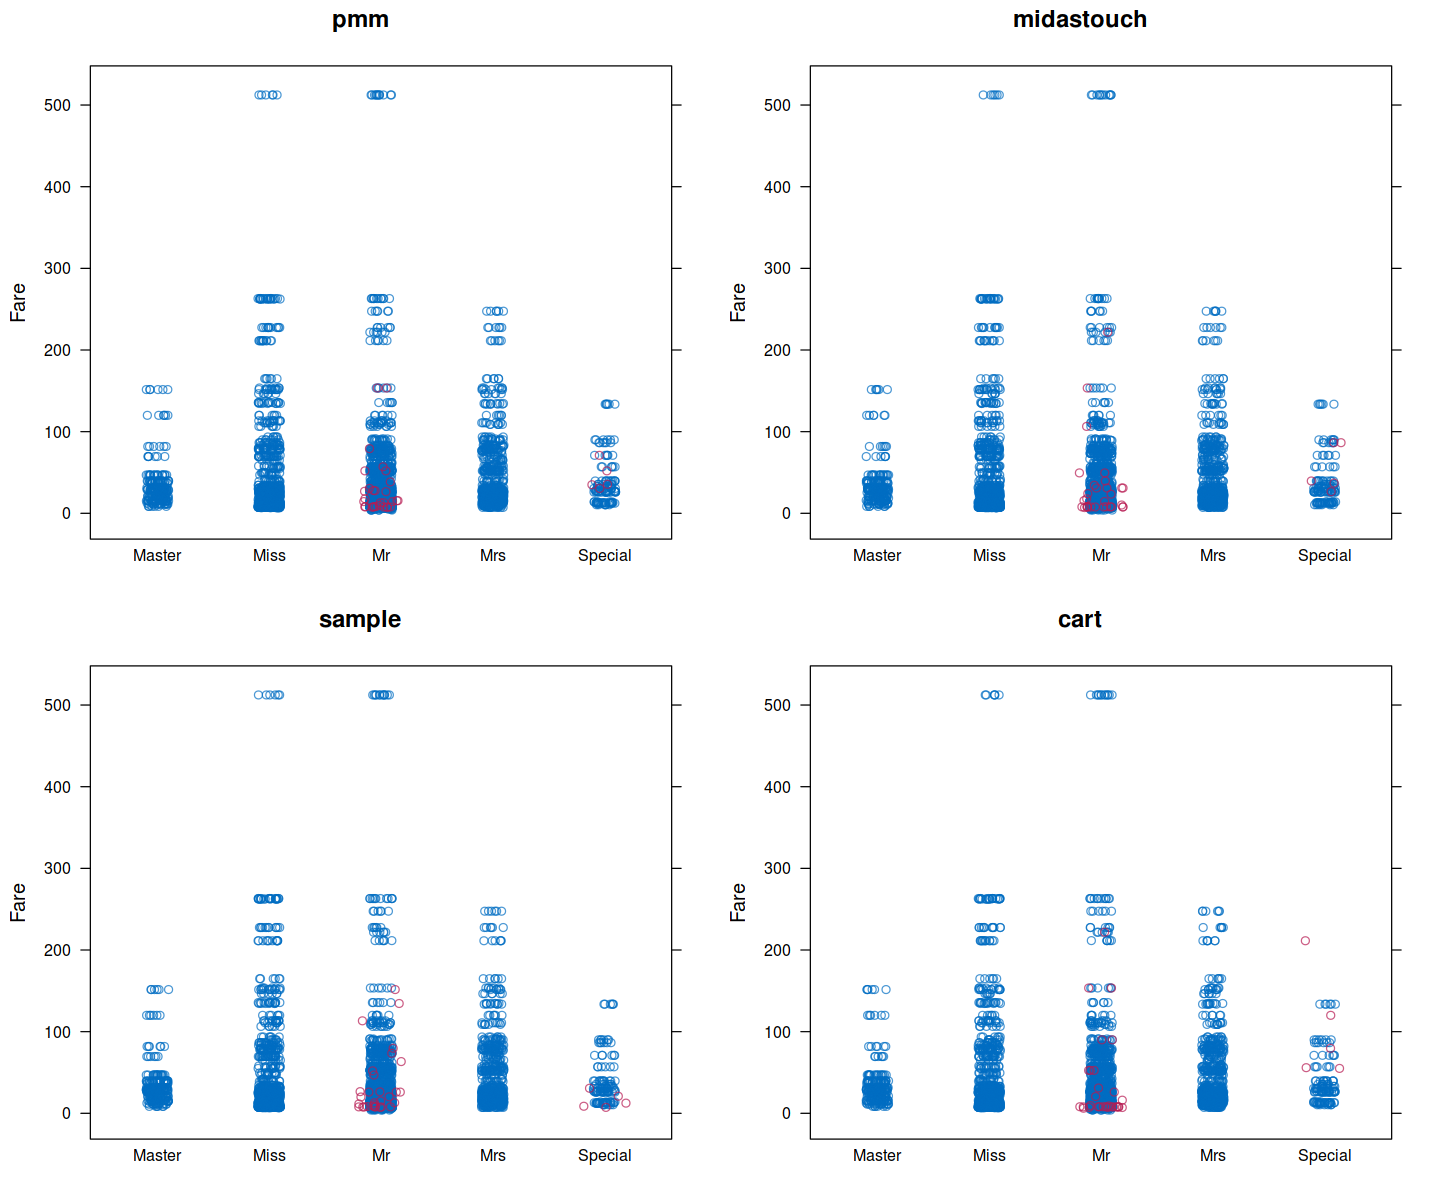

In [231]:
fare.stripplots <- lapply(fare.imps, function(imp) {stripplot(imp, Fare ~ Title, , main=imp$method["Fare"])})
grid.arrange(grobs = fare.stripplots, nrow = 2)

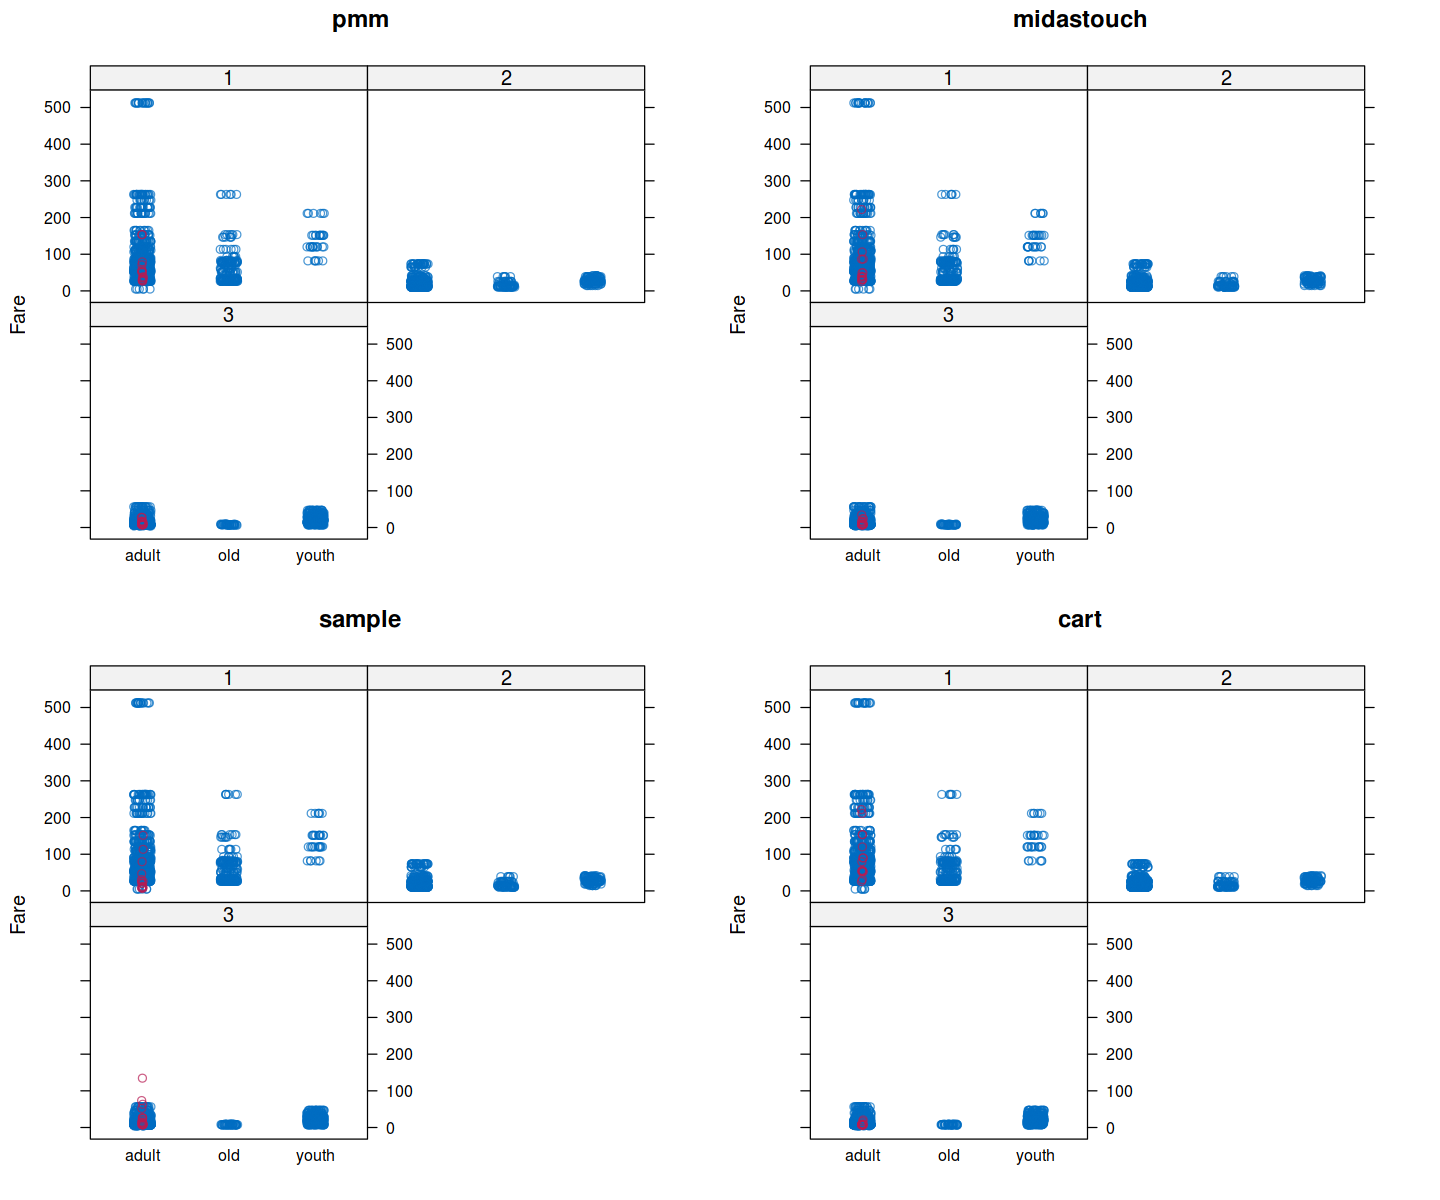

In [236]:
fare.stripplots <- lapply(fare.imps, function(imp) {stripplot(imp, Fare ~ Age.simple | Pclass, , main=imp$method["Fare"])})
options(repr.plot.height=10,repr.plot.width= 12)

grid.arrange(grobs = fare.stripplots, nrow = 2)

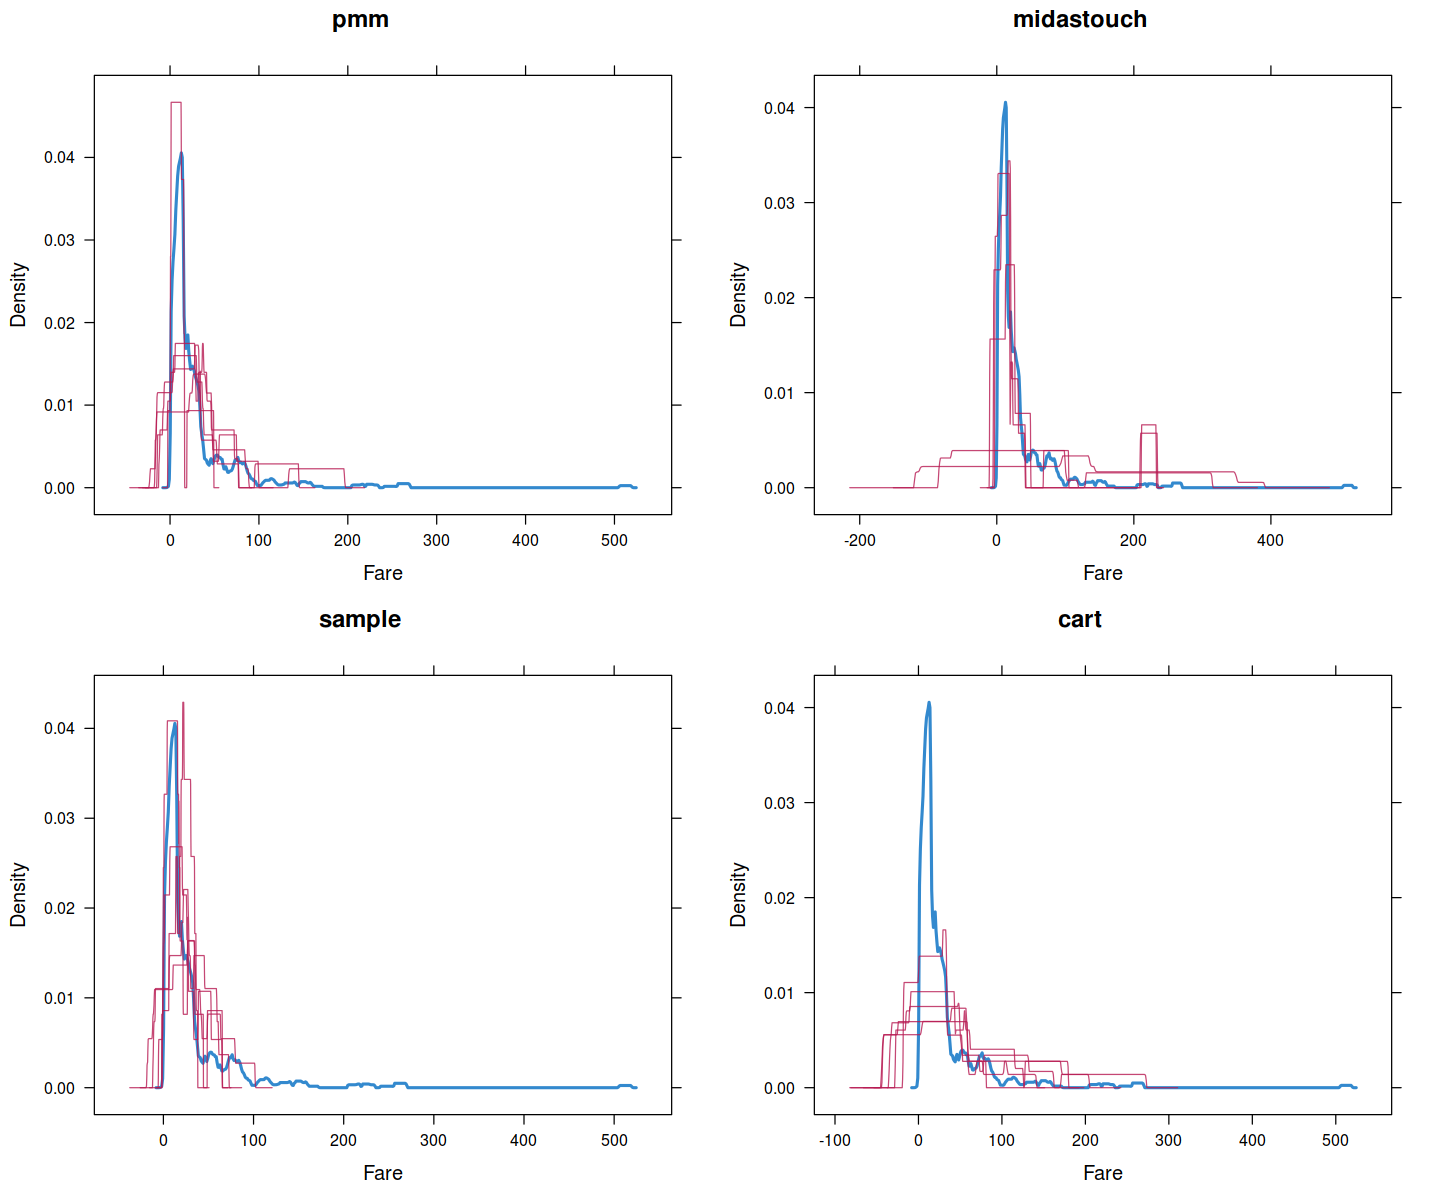

In [238]:
densityplots <- lapply(imps.fare, function(imp) {densityplot(imp, ~ Fare , main=imp$method["Fare"], kernel = "rectangular")})
grid.arrange(grobs = densityplots, nrow = 2)

In [247]:
fare <- complete(fare.imps$pmm,1)
summary(fare$Fare)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.013   7.925  14.500  32.509  31.275 512.329 